In this notebook, we formulate the task as classtical time series problem. Here we use LSTM for the time series forcasting. We use the features as the 4 hours and the label is next observation. we don't include other data like weather or holidays in the training ..

In [1]:
import numpy as np
import pandas as pd

In [2]:
"""The Data is taken from the following repository"""
!git clone https://github.com/liulingbo918/ATFM.git

Cloning into 'ATFM'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 20.94 MiB | 7.98 MiB/s, done.


In [3]:
"""The data consists of 3 components: in/outflow and Holidays and weather data"""
!ls ./ATFM/data/TaxiNYC/

Holiday.txt  Meteorology.h5  NYC2014.h5  README.md


In [4]:
import h5py

def read_h5(filename):
    data = {}
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())
        # Get the data
        for key in a_group_key:
            data[key] = list(f[key])
    return data

In [5]:
"""read flow data"""
flow_dir = "./ATFM/data/TaxiNYC/NYC2014.h5"
data = read_h5(flow_dir)
timeslot_data = np.array(data['date'])
flow_data = np.array(data['data'])

flow_data.shape, timeslot_data.shape

((17520, 2, 15, 5), (17520,))

In [6]:
"""read weather data"""
meteorology_data_dir = "./ATFM/data/TaxiNYC/Meteorology.h5"
meteorology_data = read_h5(meteorology_data_dir)
print(meteorology_data.keys())
temp_data = np.array(meteorology_data['Temperature']).reshape(17520, 1)
weather_data = np.array(meteorology_data['Weather'])
windspeed_data = np.array(meteorology_data['WindSpeed']).reshape(17520, 1)
date_data = np.array(meteorology_data['date']).reshape(17520, 1)
print(date_data.shape, weather_data.shape, windspeed_data.shape)

dict_keys(['Temperature', 'Weather', 'WindSpeed', 'date'])
(17520, 1) (17520, 17) (17520, 1)


In [7]:
"""stack all weather data into one array"""
met_data = np.hstack((temp_data, weather_data, windspeed_data))
met_data.shape

(17520, 19)

In [8]:
"""Standardize the data"""
mean = np.mean(flow_data)
std = np.std(flow_data)

flow_data_std = (flow_data-mean)/std

In [9]:
def buid_data(flow_data, x_len, y_len):
    x_flow = []
    y = []
    length = flow_data.shape[0]
    for end_idx in range(x_len + y_len, length):
        xtime = flow_data[end_idx-y_len-x_len:end_idx-y_len]
        ytime = flow_data[end_idx-y_len:end_idx]
        x_flow.append(xtime)
        y.append(ytime)
    x_flow = np.stack(x_flow)
    y = np.stack(y)
    return x_flow, y

In [10]:
"""Build data and train test split"""
x_len = 4 * 2  # 4 hours X 2 (data recorded each 30minutes)
y_len = 1  # next step
x_flow, y = buid_data(flow_data_std, x_len, y_len)
print(y.shape)
print(x_flow.shape)

xtrain = x_flow[:12279]
ytrain = y[:12279]

xval = x_flow[12279:13479]
yval = y[12279:13479]

xtest = x_flow[13479:]
ytest = y[13479:]

xtrain = xtrain.reshape(xtrain.shape[0]*5*15, 8, 2)
xval = xval.reshape(xval.shape[0]*5*15, 8, 2)
xtest = xtest.reshape(xtest.shape[0]*5*15, 8, 2)
ytrain = ytrain.reshape(ytrain.shape[0]*5*15, 2)
ytest = ytest.reshape(ytest.shape[0]*5*15, 2)
yval = yval.reshape(yval.shape[0]*5*15, 2)

print('Train:',xtrain.shape, ytrain.shape)
print('Test:',xtest.shape, ytest.shape)
print('Val:',xval.shape, yval.shape)

(17511, 1, 2, 15, 5)
(17511, 8, 2, 15, 5)
Train: (920925, 8, 2) (920925, 2)
Test: (302400, 8, 2) (302400, 2)
Val: (90000, 8, 2) (90000, 2)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

n_steps = 8 # number of time steps
n_features = 2 # inflows and outflows
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

2022-02-19 03:18:15.100774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 03:18:15.235207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 03:18:15.235888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 03:18:15.237044: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 128)            67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 102,974
Trainable params: 102,974
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(xtrain, ytrain, epochs=20, validation_data=(xval, yval), batch_size=512)

2022-02-19 03:18:17.751083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
1799/1799 [==============================] - 63s 34ms/step - loss: 0.4927 - val_loss: 0.2871
Epoch 2/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.2659 - val_loss: 0.2166
Epoch 3/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.2022 - val_loss: 0.1764
Epoch 4/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.1682 - val_loss: 0.1540
Epoch 5/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.1477 - val_loss: 0.1312
Epoch 6/20
1799/1799 [==============================] - 58s 32ms/step - loss: 0.1339 - val_loss: 0.1302
Epoch 7/20
1799/1799 [==============================] - 60s 33ms/step - loss: 0.1255 - val_loss: 0.1253
Epoch 8/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.1189 - val_loss: 0.1080
Epoch 9/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.1136 - val_loss: 0.1167
Epoch 10/20
1799/1799 [==============================] - 59s 33m

In [14]:
"""Recover original values before standardization"""
test_preds = model.predict(xtest)
test_preds = (test_preds*std)+mean
test_true = (ytest*std)+mean

In [15]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  1
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(test_true.flatten(), test_preds.flatten())))
print('MAE: ', mean_absolute_error(test_true.flatten(), test_preds.flatten()))
print('MAPE: ', mean_absolute_percentage_error(test_true.flatten(), test_preds.flatten()), "%")

RMSE:  47.12797743950383
MAE:  26.364490348807088
MAPE:  141.72271562985625 %


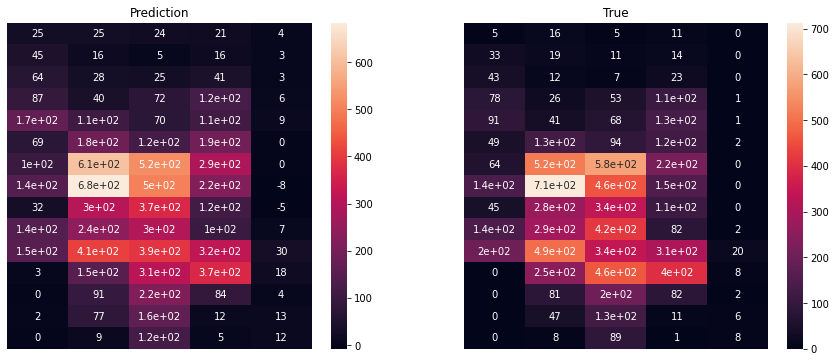

In [16]:
test_preds = test_preds.reshape(4032,2, 15, 5)
test_true = test_true.reshape(4032, 2, 15, 5)

"""Prediction of inflow at certain time slice"""

import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow_true = test_true[0, 0, :, :]
one_time_slice_inflow_preds = test_preds[0, 0, :, :]
one_time_slice_inflow_preds = one_time_slice_inflow_preds.astype(int)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

x_axis_labels = y_axis_labels = range(16,6)

sns.heatmap(one_time_slice_inflow_preds, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax1, annot=True)

sns.heatmap(one_time_slice_inflow_true, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax2, annot=True)

ax2.set_title('True')
ax1.set_title('Prediction')
plt.show()